## Analisi de dades

Primerament carreguem els datasets i visualitzem la seva informació pels diferents tipus de noticies

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import re
import os
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS # Això són les paraules "buides", que no aporten res
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
import spacy
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler
import time

data_fake = pd.read_csv('Fake.csv')
data_true = pd.read_csv('True.csv')

print('Visualització resumida de les dades de Fake News:')
data_fake.info()
print(data_fake.columns)

print()
print('Visualització resumida de les dades de True News:')
data_true.info()
print(data_true.columns)

Visualització resumida de les dades de Fake News:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB
Index(['title', 'text', 'subject', 'date'], dtype='object')

Visualització resumida de les dades de True News:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB
Index(['title', 'text', 'subject', 'date'], dtype='object')


Es pot observar que els dos datasets tenen les mateixes columnes, de manera que no caldrà ajustar el contingut a l'hora de juntar-les.
Començarem a analitzar les dades per columnes. La data no ajudarà a l'hora de classificar si una noticia és de veritat o no, de manera que eliminarem aquesta columna

In [2]:
data_fake = data_fake.drop(columns='date')
data_fake.head()

,title,text,subject
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News


In [3]:
data_true = data_true.drop(columns='date')
data_true.head()

,title,text,subject
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews


L'atribut subject sembla que podrà ajudar a l'hora de classificar, mostrarem els diferents valors que pot tenir aquest atribut per cada dataset

In [4]:
print('Diferents valors de l\'atribut subject per data_fake')
print(data_fake['subject'].unique())
print()

print('Diferents valors de l\'atribut subject per data_true')
print(data_true['subject'].unique())

Diferents valors de l'atribut subject per data_fake
['News' 'politics' 'Government News' 'left-news' 'US_News' 'Middle-east']

Diferents valors de l'atribut subject per data_true
['politicsNews' 'worldnews']


Observem que els valors son diferents entre els datasets, de manera que si l'utilitzem trobarà molt facilment quines noticies son true o fake. Eliminem la columna subject, ja que els valors que pot prendre aquesta columna en els dos datasets no intersequen.

In [5]:
data_fake = data_fake.drop(columns='subject')
data_fake.head()

,title,text
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk..."
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ..."
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...


In [6]:
data_true = data_true.drop(columns='subject')
data_true.head()

,title,text
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...


Continuem amb l'atribut text, que conté la noticia. Imprimirem alguns dels seus valors dels dos datasets.

In [7]:
print('Començament de les 5 primeres noticies dins de data_fake')
data_fake['text'].head()

Començament de les 5 primeres noticies dins de data_fake


0    Donald Trump just couldn t wish all Americans ...
1    House Intelligence Committee Chairman Devin Nu...
2    On Friday, it was revealed that former Milwauk...
3    On Christmas day, Donald Trump announced that ...
4    Pope Francis used his annual Christmas Day mes...
Name: text, dtype: object

In [8]:
print('Començament de les 5 primeres noticies dins de data_true')
data_true['text'].head()

Començament de les 5 primeres noticies dins de data_true


0    WASHINGTON (Reuters) - The head of a conservat...
1    WASHINGTON (Reuters) - Transgender people will...
2    WASHINGTON (Reuters) - The special counsel inv...
3    WASHINGTON (Reuters) - Trump campaign adviser ...
4    SEATTLE/WASHINGTON (Reuters) - President Donal...
Name: text, dtype: object

Es pot observar que casi tots els text de data_true començen per l'estat seguit de Reuters entre parentesis, si es segueix aquest patró en tot el dataset quan fem un classificador podrà trobar facilment les true news, ja que si al principi troba el patró, la majoria de vegades serà true. Buscarem aquest patró dins dels dos datasets per veure si és constant o només surt en algunes instàncies.

In [9]:
patro = "^[A-Z/]+ \(Reuters\) - "
paraula = 'Reuters'
cont = 0
c = 0
for t in data_fake['text']:
    if paraula in t:
        cont = cont + 1
    if re.match(patro, t):
        c = c + 1
print('s\'ha trobat la paraula en fake news '+str(cont)+' vegades')
print('s\'ha trobat el patró en fake news '+str(c)+' vegades')
print()
cont2 = 0
c2 = 0
for t2 in data_true['text']:
    if paraula in t2:
        cont2 = cont2 + 1
    if re.match(patro, t2):
        c2 = c2 + 1
print('s\'ha trobat la paraula en true news '+str(cont2)+' vegades')
print('s\'ha trobat el patró en true news '+str(c2)+' vegades')

s'ha trobat la paraula en fake news 311 vegades
s'ha trobat el patró en fake news 0 vegades

s'ha trobat la paraula en true news 21378 vegades
s'ha trobat el patró en true news 15742 vegades


El problema es confirma, utilitzant les dades d'aquesta manera, podrà classificar molt bé. Treiem el patró per crear un millor classificador que pugui agrupar noves notícies en fake o true, per aconseguir-ho crearem una funció que tregui el patró dessitjat d'un string i l'aplicarem a la columna text dels dos datasets.

In [10]:
def resta_patro(texte: str) -> str:
    return re.sub(patro,"",texte)

Probem la funció, mostrant les 10 primeres paraules de la primera noticia de data_true.

In [11]:
data_true["text"][0].split()[:10]

['WASHINGTON',
 '(Reuters)',
 '-',
 'The',
 'head',
 'of',
 'a',
 'conservative',
 'Republican',
 'faction']

Ara fem el mateix després d'aplicar la funció

In [12]:
resta_patro(data_true["text"][0]).split()[:10]

['The',
 'head',
 'of',
 'a',
 'conservative',
 'Republican',
 'faction',
 'in',
 'the',
 'U.S.']

Ara que sabem que funciona correctament, l'apliquem a totes les files de data_true

In [13]:
data_true["text"] = data_true["text"].apply(resta_patro)
data_true

,title,text
0,"As U.S. budget fight looms, Republicans flip t...",The head of a conservative Republican faction ...
1,U.S. military to accept transgender recruits o...,Transgender people will be allowed for the fir...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,The special counsel investigation of links bet...
3,FBI Russia probe helped by Australian diplomat...,Trump campaign adviser George Papadopoulos tol...
4,Trump wants Postal Service to charge 'much mor...,President Donald Trump called on the U.S. Post...
...,...,...
21412,'Fully committed' NATO backs new U.S. approach...,NATO allies on Tuesday welcomed President Dona...
21413,LexisNexis withdrew two products from Chinese ...,"LexisNexis, a provider of legal, regulatory an..."
21414,Minsk cultural hub becomes haven from authorities,In the shadow of disused Soviet-era factories ...
21415,Vatican upbeat on possibility of Pope Francis ...,Vatican Secretary of State Cardinal Pietro Par...


Farem un word cloud per cada dataset per veure les paraules més utilitzades

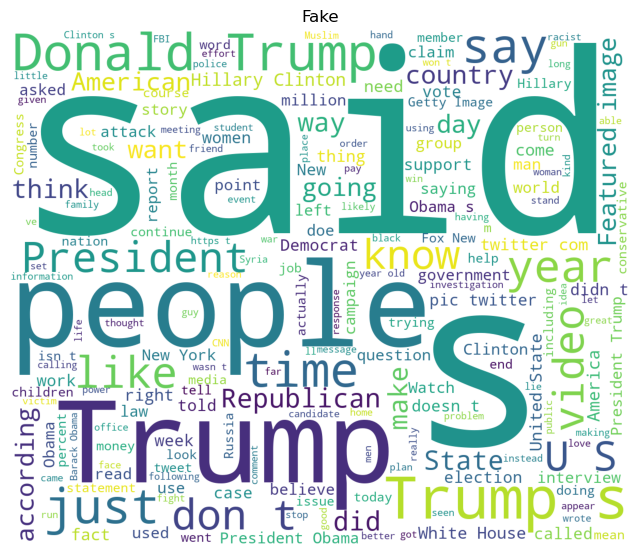

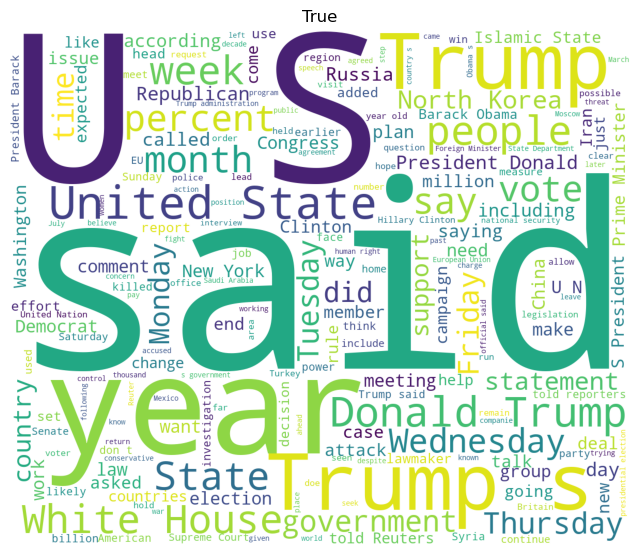

In [14]:
fals = ' '.join(data_fake['title']) + ' '.join(data_fake['text'])
veritat = ' '.join(data_true['title']) + ' '.join(data_true['text'])

wordcloud_fake = WordCloud(stopwords=ENGLISH_STOP_WORDS, background_color='white', width=1200, height=1000).generate(fals)
wordcloud_true = WordCloud(stopwords=ENGLISH_STOP_WORDS, background_color='white', width=1200, height=1000).generate(veritat)

plt.figure(figsize = [8, 7])
plt.imshow(wordcloud_fake)
plt.axis('off')
plt.title('Fake')
plt.show()

plt.figure(figsize = [8, 7])
plt.imshow(wordcloud_true)
plt.axis('off')
plt.title('True')
plt.show()

Podem observar que les paraules que apareixen en el titol o el text no ajuden a fer cap diferenciació, ja que les més repetides són molt semblants entre els dos datasets.

Finalment, afegim una nova columna que ens digui si la noticia és de veritat (1) o no (0)

In [15]:
data_true["tipus"] = 1
data_true.head()

,title,text,tipus
0,"As U.S. budget fight looms, Republicans flip t...",The head of a conservative Republican faction ...,1
1,U.S. military to accept transgender recruits o...,Transgender people will be allowed for the fir...,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,The special counsel investigation of links bet...,1
3,FBI Russia probe helped by Australian diplomat...,Trump campaign adviser George Papadopoulos tol...,1
4,Trump wants Postal Service to charge 'much mor...,President Donald Trump called on the U.S. Post...,1


In [16]:
data_fake["tipus"] = 0
data_fake.head()

,title,text,tipus
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,0


Juntem els dos datasets per crear el conjunt de dades que utilitzarem per entrenar

In [17]:
data = pd.concat([data_fake, data_true])

## Models

Investigant com aconseguir gestionar els textos per fer un classificador trobem que podem utilitzar TF-IDF. Aquest és una estadística numerica que busca donar un valor d'importància a una paraula dins d'un conjunt de textes, incrementant proporcionalment al número de vegades que la paraula apareix dins un document i es compensa amb el número de documents que la contenen.<br>
També trobem pipelines entrenades de spacy.<br>
Finalment trobem word-embeddings pre entrenats de GloVe per obtenir representacions vectorials de paraules. L'entrenament es realitza sobre estadístiques globals agregades de co-ocurrència paraula-paraula d'un corpus, i les representacions resultants mostren subestructures lineals de l'espai vectorial de paraules.

Farem tres models diferents:
    <li>Random forest
    <li>Naive Bayes
    <li>Xarxa Neuronal

#### Random Forest

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      4676
           1       0.99      1.00      0.99      4304

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980

Accuracy: 0.9948775055679288


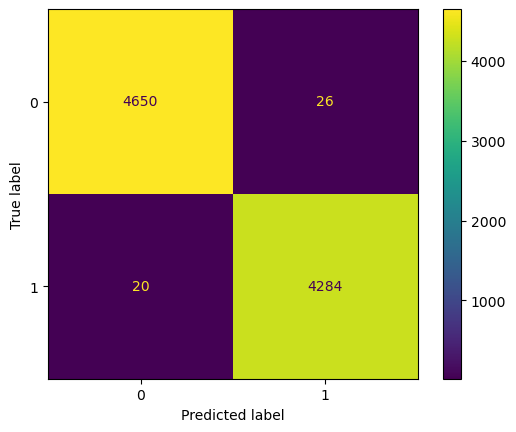

S'ha trigat 396.6989688873291 segons


In [18]:
tRFi = time.time()
# Juntem titol i cos de la noticia
X = data['title'] + ' ' + data['text']
y = data['tipus']

# Treiem puntuació i les stop words de l'anglés
puntuacio = re.compile(r'[^\w\s]+')
X = X.apply(lambda x: ' '.join([item for item in x.split() if item not in ENGLISH_STOP_WORDS]))
X = X.apply(lambda x: puntuacio.sub('', str(x)))

# Separem les dades en 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

# Preparem la pipeline del model utilitzant TF-IDF per transformar el text
pipeline = Pipeline(
    [
        ('vect', TfidfVectorizer(lowercase=True, max_features=10000, ngram_range=(1,2))),
        ('clf', RandomForestClassifier(max_features='sqrt', n_estimators=1000, n_jobs=-1))
    ]
)

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)

punts = cross_validate(pipeline, X_train, y_train, scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'],
                        cv=5, n_jobs=-1, return_train_score=False)

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
disp.plot()
plt.show()
print(f"S'ha trigat {time.time() - tRFi} segons")

#### Naive Bayes

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
Utilitzem spacy per convertir el text en un vector de paraules
Separem les dades en 80/20
Executem Naive Bayes
              precision    recall  f1-score   support

           0       0.90      0.84      0.87      4676
           1       0.84      0.90      0.87      4304

    accuracy                           0.87      8980
   macro avg       0.87      0.87      0.87      8980
weighted avg       0.87      0.87      0.87      8980

Accuracy: 0.8679287305122494


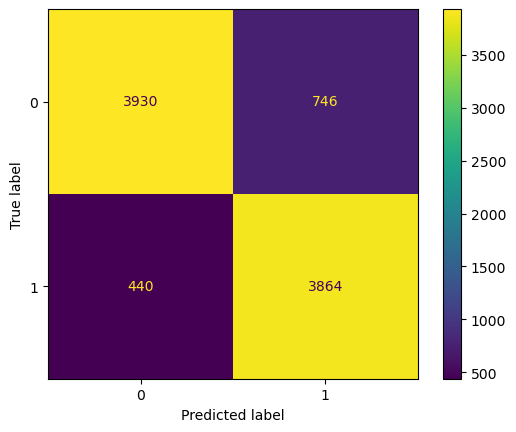

S'ha trigat 2476.309182405472 segons


In [19]:
tNBi = time.time()
spacy.cli.download("en_core_web_lg")
print("Utilitzem spacy per convertir el text en un vector de paraules")
text_a_vector_paraules = spacy.load('en_core_web_lg') # en_core_web_lg es una pipeline entrenada per l'anglés
# Afegim una nova columna pel vector 
data['vector_text'] = data['text'].apply(lambda x: text_a_vector_paraules(x).vector)

print("Separem les dades en 80/20")
X_trainNB, X_testNB, y_trainNB, y_testNB = train_test_split(data['vector_text'],data['tipus'],test_size = 0.2,random_state = 10)

#Juntem els atributs
X_train_junt = np.stack(X_trainNB)
X_test_junt = np.stack(X_testNB)

# No volem valors negatius, així que reescalem a valors ente 0 i 1 amb MinMaxScaler
escalat = MinMaxScaler()
X_train_escalat = escalat.fit_transform(X_train_junt)
X_test_escalat = escalat.transform(X_test_junt)

print("Executem Naive Bayes")
clf = MultinomialNB()
clf.fit(X_train_escalat, y_trainNB)

y_predNB = clf.predict(X_test_escalat)

print(classification_report(y_testNB, y_predNB))
print(f"Accuracy: {accuracy_score(y_testNB, y_predNB)}")

cmNB = confusion_matrix(y_testNB, y_predNB)
dispNB = ConfusionMatrixDisplay(confusion_matrix=cmNB, display_labels=['0', '1'])
dispNB.plot()
plt.show()
print(f"S'ha trigat {time.time() - tNBi} segons")

#### Xarxa neuronal amb GloVe

Hi ha 400000 vectors de paraules.
Epoch 1/16
66/66 [==============================] - 299s 4s/step - loss: 0.6153 - acc: 0.8628 - val_loss: 0.2797 - val_acc: 0.8881
Epoch 2/16
66/66 [==============================] - 177s 3s/step - loss: 0.0638 - acc: 0.9788 - val_loss: 0.3233 - val_acc: 0.8756
Epoch 3/16
66/66 [==============================] - 192s 3s/step - loss: 0.0191 - acc: 0.9961 - val_loss: 0.2433 - val_acc: 0.9126
Epoch 4/16
66/66 [==============================] - 177s 3s/step - loss: 0.0082 - acc: 0.9990 - val_loss: 0.2560 - val_acc: 0.9120
Epoch 5/16
66/66 [==============================] - 176s 3s/step - loss: 0.0046 - acc: 0.9998 - val_loss: 0.2687 - val_acc: 0.9111
Epoch 6/16
66/66 [==============================] - 178s 3s/step - loss: 0.0031 - acc: 0.9998 - val_loss: 0.2929 - val_acc: 0.9067
Epoch 7/16
66/66 [==============================] - 174s 3s/step - loss: 0.0022 - acc: 0.9998 - val_loss: 0.2894 - val_acc: 0.9103
Epoch 8/16
66/66 [==============================]

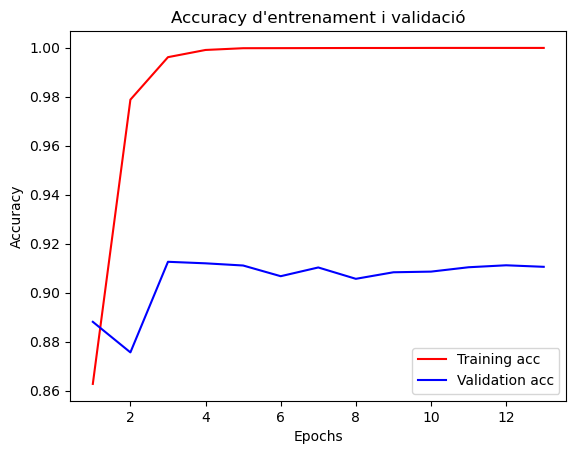

S'ha trigat 2446.822133541107 segons


In [20]:
tXNi = time.time()
ep = 16
features = data[["title", "text"]]
labels = data["tipus"]
features_dict = {name: np.array(value) for name, value in features.items()}

def get_output_sequence_length(column):
    lengths = [len(x.split()) for x in column]
    return max(lengths)

inputs = {}
for name, column in features.items():    
    inputs[name] = tf.keras.Input(shape=(1,), name=name, dtype=tf.string)
    
outputs = []
for name, input in inputs.items():
    output_sequence_length = get_output_sequence_length(features[name])
    text_vectorizer = tf.keras.layers.TextVectorization(output_sequence_length=output_sequence_length)
    text_vectorizer.adapt(features[name])
    
    x = text_vectorizer(input)
    outputs.append(x)
    
preprocessing_model = tf.keras.Model(inputs, outputs)

embeddings_index = {}
# Important descarregar l'arxiu a la mateixa carpeta on es troba el notebook!!
f = open("glove.6B.100d.txt", "r", encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype="float32")
    embeddings_index[word] = coefs
f.close()

embedding_matrix = np.zeros((text_vectorizer.vocabulary_size(), 100))
for i, word in enumerate(text_vectorizer.get_vocabulary()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

print(f"Hi ha {len(embeddings_index)} vectors de paraules.")

embedding_layer = tf.keras.layers.Embedding(
    input_dim=text_vectorizer.vocabulary_size(),
    output_dim=100,
    weights=[embedding_matrix],
    input_length=100,
    trainable=False
)

preprocessed_inputs = preprocessing_model(inputs)

all_inputs = [embedding_layer(input) for input in preprocessed_inputs]

flatten_layer = tf.keras.layers.Flatten()
flat_inputs = [flatten_layer(input) for input in all_inputs]

x = tf.keras.layers.Concatenate()(flat_inputs)

x = tf.keras.layers.Dense(units=128, activation="relu")(x)
outputs = tf.keras.layers.Dense(units=1, activation="sigmoid")(x)

training_model = tf.keras.Model(inputs, outputs)

training_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["acc"])

callbacks = [tf.keras.callbacks.EarlyStopping(patience=10)]

history = training_model.fit(x=features_dict, y=labels, epochs=ep, callbacks=callbacks, validation_split=0.25, batch_size=512)

history_dict = history.history
epochs = range(1, len(history_dict["acc"]) + 1)

plt.clf()
acc_values = history_dict["acc"]
val_acc_values = history_dict["val_acc"]

plt.plot(epochs, acc_values, 'r', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Accuracy d\'entrenament i validació')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

print(f"S'ha trigat {time.time() - tXNi} segons")

## Conclusions

La base de dades proporcionada conté pocs atributs, i d'aquests, molts no estàn relacionats amb l'atribut objectiu. De manera que és difícil fer un model apropiat.<br>
A més a més de ser una base de dades que necessita molta neteja per poder treballar sense esbiaixar el model, ja que hi ha atributs que només corresponen a una classe no per ser significants, si no per una mala asignació:
<li>columna subject on els valors possibles no tenen relació entre true i fake news
<li>columna text, on la majoria de noticies de veritat contenen el patró "[Estat] - (Reuters)".<br>
Es pot observar que amb el Random Forest ja s'aconsegueix un molt bon model, a més de ser més senzill i ràpid que els altres.